In [1]:
import nltk
nltk.download('punkt_tab')

import re

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Terra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Load Data and EDA

In [4]:
train = pd.read_csv('../content/train.csv', encoding='latin-1')
test = pd.read_csv('../content/test.csv', encoding='latin-1')

In [5]:
train.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [6]:
train.dropna(inplace=True)
test.dropna(inplace=True)
train.drop_duplicates(inplace=True)
test.drop_duplicates(inplace=True)

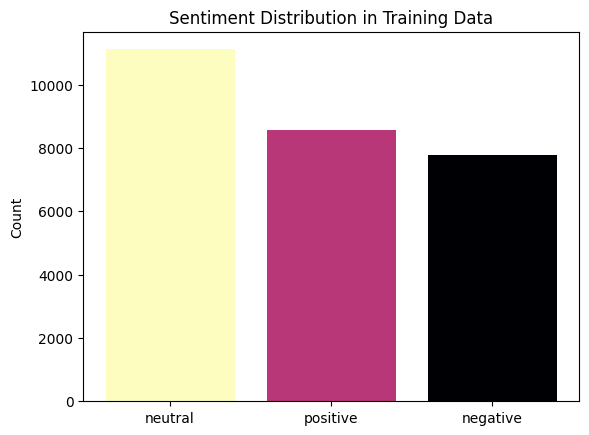

In [7]:
sentiment_counts = train['sentiment'].value_counts()

ranks = np.argsort(np.argsort(sentiment_counts.values))
colors = plt.cm.magma (ranks / max(ranks))

plt.bar(sentiment_counts.index, sentiment_counts.values, color=colors)
plt.ylabel("Count")
plt.title("Sentiment Distribution in Training Data")
plt.show()

Use only text and sentiment columns

In [8]:
col = ['text', 'sentiment']

train_df = train[col]
test_df = test[col]

## Prepare Sentiment Labels

In [9]:
sentiment_to_index = {
    'negative': 0,
    'neutral': 1,
    'positive': 2
  }

train_df.loc[:, 'sentiment'] = train_df['sentiment'].map(sentiment_to_index)
test_df.loc[:, 'sentiment'] = test_df['sentiment'].map(sentiment_to_index)

In [10]:
train_df.head()

,text,sentiment
0,"I`d have responded, if I were going",1
1,Sooo SAD I will miss you here in San Diego!!!,0
2,my boss is bullying me...,0
3,what interview! leave me alone,0
4,"Sons of ****, why couldn`t they put them on t...",0


## Prepare Text Data

### Adjust Words based on REGEX

In [11]:
def remove_special_character(text):
    text=re.sub('<.*?>', ' ', text)
    text=re.sub('<.*>','',text)
    text=re.sub('http\S+|https\S+|www\S+','',text)
    text=re.sub('@\S+|#\S+','',text)
    text = re.sub('`', "'",  text)
    # Keep apostrophes only if inside words (like "I'm", "don't")
    text = re.sub(r"[^\w\s']", '', text)
    return text

<>:4: SyntaxWarning: invalid escape sequence '\S'
<>:5: SyntaxWarning: invalid escape sequence '\S'
<>:4: SyntaxWarning: invalid escape sequence '\S'
<>:5: SyntaxWarning: invalid escape sequence '\S'
C:\Users\Terra\AppData\Local\Temp\ipykernel_22984\205953668.py:4: SyntaxWarning: invalid escape sequence '\S'
  text=re.sub('http\S+|https\S+|www\S+','',text)
C:\Users\Terra\AppData\Local\Temp\ipykernel_22984\205953668.py:5: SyntaxWarning: invalid escape sequence '\S'
  text=re.sub('@\S+|#\S+','',text)


In [12]:
import contractions

# couldn't -> could not
def expand_contractions(text):
    text = contractions.fix(text)
    return text

In [13]:
train_df.loc[:, 'text'] = train_df['text'].str.lower().str.strip().apply(remove_special_character).apply(expand_contractions)
test_df.loc[:, 'text'] = test_df['text'].str.lower().str.strip().apply(remove_special_character).apply(expand_contractions)

In [14]:
train_df.head()

,text,sentiment
0,i would have responded if i were going,1
1,sooo sad i will miss you here in san diego,0
2,my boss is bullying me,0
3,what interview leave me alone,0
4,sons of why could not they put them on the re...,0


### Convert to List

In [15]:
train_text = [text for text in train_df['text']]
train_label = [label for label in train_df['sentiment']]

test_text = [text for text in test_df['text']]
test_label = [label for label in test_df['sentiment']]

## Data Prediction
### Initialize Tweet Roberta Pipeline from Hugging Face

In [17]:
from transformers import pipeline

sentiment_model = pipeline("text-classification", model="cardiffnlp/twitter-roberta-base-sentiment-latest")

C:\Users\Terra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Terra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Terra\.cache\huggingface\hub\models--cardiffnlp--twitter-roberta-base-sentiment-latest. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://hug

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


In [18]:
from tqdm import tqdm

test_preds = [sentiment_model(text)[0] for text in tqdm(test_text, desc="Processing Sentiment")]

Processing Sentiment: 100%|██████████| 3534/3534 [02:09<00:00, 27.30it/s]


In [19]:
test_preds[0:3]

[{'label': 'neutral', 'score': 0.9128071069717407},
 {'label': 'positive', 'score': 0.9858922362327576},
 {'label': 'negative', 'score': 0.9281763434410095}]

In [20]:
test_label[0:3]

[1, 2, 0]

### Evaluation

In [21]:
class_names = ['Negative', 'Neutral', 'Positive']
test_label_mapped = [class_names[label] for label in test_label]

label_map = {"negative": "Negative", "neutral": "Neutral", "positive": "Positive"}
test_preds_mapped = [label_map[pred['label']] for pred in test_preds]

report = classification_report(test_label_mapped, test_preds_mapped, target_names=class_names)
print(report)

              precision    recall  f1-score   support

    Negative       0.67      0.81      0.73      1001
     Neutral       0.75      0.56      0.64      1430
    Positive       0.76      0.85      0.80      1103

    accuracy                           0.72      3534
   macro avg       0.72      0.74      0.72      3534
weighted avg       0.73      0.72      0.72      3534



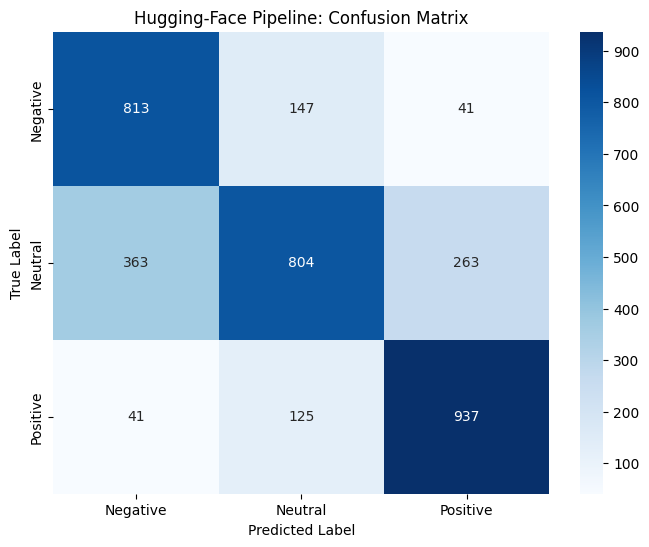

In [22]:
cm = confusion_matrix(test_label_mapped, test_preds_mapped)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Hugging-Face Pipeline: Confusion Matrix")
plt.show()